Using device: cuda
Training samples: 2268
Validation samples: 189
Test samples: 189


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Total parameters: 7,763,905
Starting training...

Epoch 1/200


Val batch: 100%|██████████| 95/95 [00:07<00:00, 12.69it/s]


Train Loss: 0.622347
Val Loss: 0.565599 | IoU: 0.2324 | Dice: 0.3772 | F1: 0.3772
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.565599

Epoch 2/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.64it/s]


Train Loss: 0.508768
Val Loss: 0.473407 | IoU: 0.3320 | Dice: 0.4984 | F1: 0.4984
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.473407

Epoch 3/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.57it/s]


Train Loss: 0.456711
Val Loss: 0.427214 | IoU: 0.3633 | Dice: 0.5330 | F1: 0.5330
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.427214

Epoch 4/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.58it/s]


Train Loss: 0.429156
Val Loss: 0.428681 | IoU: 0.3554 | Dice: 0.5244 | F1: 0.5244
Learning Rate: 2.00e-04

Epoch 5/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 18.22it/s]


Train Loss: 0.410854
Val Loss: 0.423225 | IoU: 0.3767 | Dice: 0.5473 | F1: 0.5473
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.423225

Epoch 6/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.23it/s]


Train Loss: 0.399896
Val Loss: 0.404387 | IoU: 0.3942 | Dice: 0.5655 | F1: 0.5655
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.404387

Epoch 7/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.32it/s]


Train Loss: 0.389841
Val Loss: 0.384654 | IoU: 0.4168 | Dice: 0.5883 | F1: 0.5883
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.384654

Epoch 8/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.62it/s]


Train Loss: 0.377066
Val Loss: 0.372869 | IoU: 0.4313 | Dice: 0.6027 | F1: 0.6027
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.372869

Epoch 9/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.89it/s]


Train Loss: 0.367527
Val Loss: 0.442787 | IoU: 0.3763 | Dice: 0.5468 | F1: 0.5468
Learning Rate: 2.00e-04

Epoch 10/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.78it/s]


Train Loss: 0.357734
Val Loss: 0.363900 | IoU: 0.4232 | Dice: 0.5947 | F1: 0.5947
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.363900

Epoch 11/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.61it/s]


Train Loss: 0.348957
Val Loss: 0.366762 | IoU: 0.4278 | Dice: 0.5992 | F1: 0.5992
Learning Rate: 2.00e-04

Epoch 12/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.81it/s]


Train Loss: 0.337349
Val Loss: 0.387493 | IoU: 0.4080 | Dice: 0.5796 | F1: 0.5796
Learning Rate: 2.00e-04

Epoch 13/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.65it/s]


Train Loss: 0.326312
Val Loss: 0.424994 | IoU: 0.3522 | Dice: 0.5210 | F1: 0.5210
Learning Rate: 2.00e-04

Epoch 14/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.70it/s]


Train Loss: 0.316973
Val Loss: 0.356675 | IoU: 0.4589 | Dice: 0.6291 | F1: 0.6291
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.356675

Epoch 15/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.41it/s]


Train Loss: 0.305336
Val Loss: 0.406445 | IoU: 0.4108 | Dice: 0.5824 | F1: 0.5824
Learning Rate: 2.00e-04

Epoch 16/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.94it/s]


Train Loss: 0.295611
Val Loss: 0.364283 | IoU: 0.4606 | Dice: 0.6307 | F1: 0.6307
Learning Rate: 2.00e-04

Epoch 17/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.92it/s]


Train Loss: 0.286988
Val Loss: 0.359662 | IoU: 0.4680 | Dice: 0.6376 | F1: 0.6376
Learning Rate: 2.00e-04

Epoch 18/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 18.25it/s]


Train Loss: 0.280715
Val Loss: 0.374313 | IoU: 0.4465 | Dice: 0.6173 | F1: 0.6173
Learning Rate: 2.00e-04

Epoch 19/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 18.01it/s]


Train Loss: 0.270338
Val Loss: 0.382548 | IoU: 0.4472 | Dice: 0.6180 | F1: 0.6180
Learning Rate: 2.00e-04

Epoch 20/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 18.22it/s]


Train Loss: 0.259640
Val Loss: 0.434405 | IoU: 0.4144 | Dice: 0.5859 | F1: 0.5859
Learning Rate: 2.00e-04

Epoch 21/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.92it/s]


Train Loss: 0.253108
Val Loss: 0.404134 | IoU: 0.4417 | Dice: 0.6128 | F1: 0.6128
Learning Rate: 2.00e-04

Epoch 22/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 18.08it/s]


Train Loss: 0.245615
Val Loss: 0.406275 | IoU: 0.4412 | Dice: 0.6122 | F1: 0.6122
Learning Rate: 1.40e-04

Epoch 23/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 18.14it/s]


Train Loss: 0.223972
Val Loss: 0.384905 | IoU: 0.4560 | Dice: 0.6264 | F1: 0.6264
Learning Rate: 1.40e-04

Epoch 24/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 17.95it/s]


Train Loss: 0.217886
Val Loss: 0.415693 | IoU: 0.4384 | Dice: 0.6095 | F1: 0.6095
Learning Rate: 1.40e-04
Early stopping triggered after 24 epochs


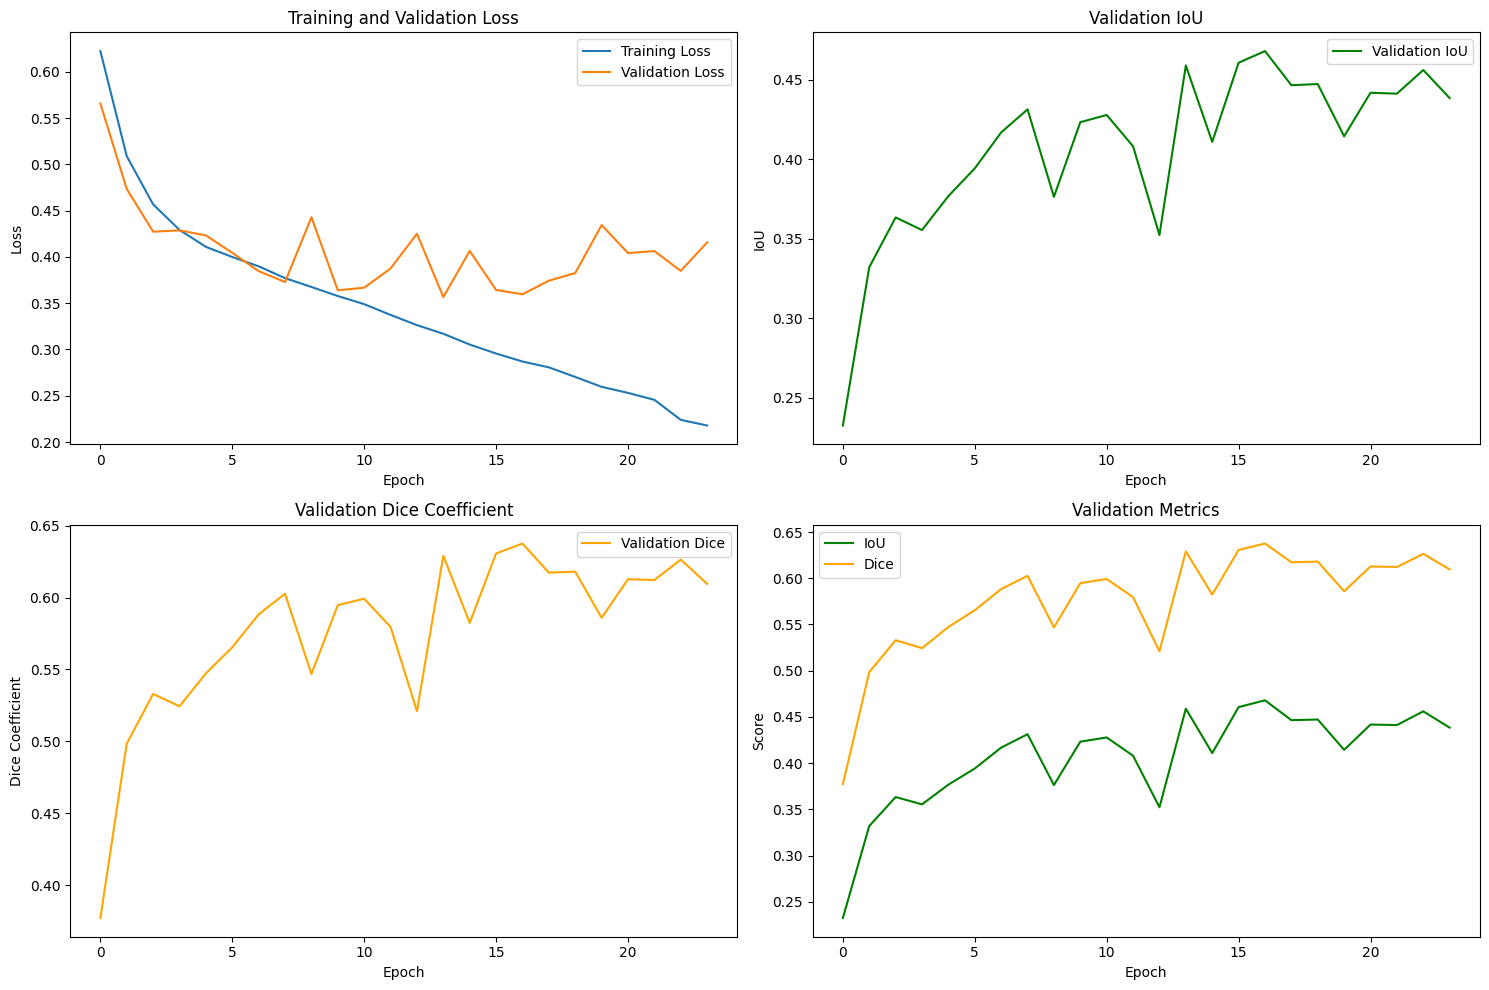

Loading best model for test evaluation...

Evaluating on test set...


Val batch: 100%|██████████| 189/189 [00:10<00:00, 18.64it/s]


UNET4 TEST EVALUATION METRICS
Test set processed with batch_size=1
Loss:            0.338392
IoU:             0.4677
Dice Coefficient: 0.6374
Accuracy:        0.9213
Precision:       0.6232
Recall:          0.6522
F1-Score:        0.6374
Confusion matrix (pixel-level):
[[10555269   517896]
 [  456691   856448]]
Training and evaluation completed!


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------
# UNet4 Architecture with Regularization (Updated)
# -------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_rate=0.1, use_dropout=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        
        layers.extend([
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ])
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        
        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)

class UNet4(nn.Module):
    """U-Net with 4 encoder blocks, bottleneck, and 4 decoder blocks with regularization"""
    def __init__(self, in_channels=6, out_channels=1, features=[32, 64, 128, 256], dropout_rate=0.15):
        super().__init__()
        # Reduced feature sizes to prevent overfitting
        
        # 4 Encoder blocks (no dropout in encoder layers)
        self.enc1 = DoubleConv(in_channels, features[0], dropout_rate, use_dropout=False)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(features[0], features[1], dropout_rate, use_dropout=False)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(features[1], features[2], dropout_rate, use_dropout=False)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(features[2], features[3], dropout_rate = 0.1, use_dropout=True)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck with higher dropout rate
        self.bottleneck = DoubleConv(features[3], features[3]*2, dropout_rate = 0.5, use_dropout=True)

        # 4 Decoder blocks with dropout in middle layers
        self.up4 = nn.ConvTranspose2d(features[3]*2, features[3], kernel_size=2, stride=2)
        self.dec4 = DoubleConv(features[3]*2, features[3], dropout_rate, use_dropout=True)
        self.up3 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.dec3 = DoubleConv(features[2]*2, features[2], dropout_rate, use_dropout=True)
        self.up2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.dec2 = DoubleConv(features[1]*2, features[1], dropout_rate, use_dropout=True)
        self.up1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.dec1 = DoubleConv(features[0]*2, features[0], dropout_rate, use_dropout=True)

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        e3 = self.enc3(p2); p3 = self.pool3(e3)
        e4 = self.enc4(p3); p4 = self.pool4(e4)
        
        # Bottleneck
        b = self.bottleneck(p4)
        
        # Decoder path with skip connections
        d4 = self.up4(b); d4 = torch.cat([d4, e4], dim=1); d4 = self.dec4(d4)
        d3 = self.up3(d4); d3 = torch.cat([d3, e3], dim=1); d3 = self.dec3(d3)
        d2 = self.up2(d3); d2 = torch.cat([d2, e2], dim=1); d2 = self.dec2(d2)
        d1 = self.up1(d2); d1 = torch.cat([d1, e1], dim=1); d1 = self.dec1(d1)
        
        # Output (return logits, not sigmoid)
        out = self.final_conv(d1)
        return out

class EarthquakeDataset(Dataset):
    """Custom dataset for earthquake damage assessment"""
    def __init__(self, root_dir, split='train', transform=None, img_size=(256, 256)):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.img_size = img_size
        
        # Set paths based on split
        if split == 'train':
            self.pre_dir = os.path.join(root_dir, 'train', 'A_train_aug')
            self.post_dir = os.path.join(root_dir, 'train', 'B_train_aug')
            self.label_dir = os.path.join(root_dir, 'train', 'label_train_aug')
        elif split == 'val':
            self.pre_dir = os.path.join(root_dir, 'val', 'A_val')
            self.post_dir = os.path.join(root_dir, 'val', 'B_val')
            self.label_dir = os.path.join(root_dir, 'val', 'label_val')
        else:  # test
            self.pre_dir = os.path.join(root_dir, 'test', 'A_test')
            self.post_dir = os.path.join(root_dir, 'test', 'B_test')
            self.label_dir = os.path.join(root_dir, 'test', 'label_test')
        
        # Get list of image files
        self.image_files = sorted([f for f in os.listdir(self.pre_dir) if f.endswith('.png')])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        
        # Load images
        pre_img = Image.open(os.path.join(self.pre_dir, img_name)).convert('RGB')
        post_img = Image.open(os.path.join(self.post_dir, img_name)).convert('RGB')
        label = Image.open(os.path.join(self.label_dir, img_name)).convert('L')
        
        # Resize images
        pre_img = pre_img.resize(self.img_size)
        post_img = post_img.resize(self.img_size)
        label = label.resize(self.img_size)
        
        # Convert to tensors
        if self.transform:
            pre_img = self.transform(pre_img)
            post_img = self.transform(post_img)
        else:
            pre_img = transforms.ToTensor()(pre_img)
            post_img = transforms.ToTensor()(post_img)
        
        label = transforms.ToTensor()(label)
        
        # Ensure binary labels (0 or 1)
        label = (label > 0.5).float()
        
        # Concatenate pre and post images (6 channels total)
        combined_img = torch.cat([pre_img, post_img], dim=0)
        
        return combined_img, label

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve (Updated)"""
    def __init__(self, patience=15, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        """Saves model when validation loss decreases."""
        self.best_weights = model.state_dict().copy()

# -------------------------
# Losses & Metrics (Updated)
# -------------------------
def dice_coef(pred, target, smooth=1e-6):
    """Calculate dice coefficient"""
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    denom = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (denom + smooth)
    return dice.mean()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        dice = dice_coef(pred, target, smooth=self.smooth)
        return 1.0 - dice

def combined_loss(logits, mask, bce_weight=0.6, dice_weight=0.4):
    """Combined BCE + Dice loss with balanced weights"""
    bce_loss = nn.BCEWithLogitsLoss()
    bce = bce_loss(logits, mask)
    probs = torch.sigmoid(logits)
    dice = DiceLoss()(probs, mask)
    return bce_weight * bce + dice_weight * dice

@torch.no_grad()
def compute_metrics_batch(logits, masks, thresh=0.5):
    """Compute metrics for a batch"""
    probs = torch.sigmoid(logits)
    preds = (probs >= thresh).float()
    preds_flat = preds.view(-1).cpu().numpy()
    masks_flat = masks.view(-1).cpu().numpy()
    
    # Handle edge case where all predictions or targets are same class
    unique_preds = np.unique(preds_flat)
    unique_masks = np.unique(masks_flat)
    
    if len(unique_preds) == 1 and len(unique_masks) == 1:
        if unique_preds[0] == unique_masks[0]:
            # Perfect prediction
            if unique_preds[0] == 1:
                tp, fp, fn, tn = len(preds_flat), 0, 0, 0
            else:
                tp, fp, fn, tn = 0, 0, 0, len(preds_flat)
        else:
            # Completely wrong prediction
            if unique_preds[0] == 1:
                tp, fp, fn, tn = 0, len(preds_flat), 0, 0
            else:
                tp, fp, fn, tn = 0, 0, len(preds_flat), 0
    else:
        cm = confusion_matrix(masks_flat, preds_flat, labels=[0,1])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            # Handle case where only one class present
            if cm.shape == (1, 1):
                if unique_masks[0] == 0:
                    tn, fp, fn, tp = cm[0,0], 0, 0, 0
                else:
                    tn, fp, fn, tp = 0, 0, 0, cm[0,0]
            else:
                tn, fp, fn, tp = 0, 0, 0, 0
    
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    return {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
            "iou": float(iou), "dice": float(dice), "precision": float(precision),
            "recall": float(recall), "f1": float(f1), "acc": float(acc)}

# -------------------------
# Training & Validation Functions (Updated)
# -------------------------
def train_one_epoch(model, loader, optimizer, scheduler=None):
    """Train for one epoch with gradient clipping"""
    model.train()
    running_loss = 0.0
    for imgs, masks in tqdm(loader, desc="Train batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    
    if scheduler is not None:
        scheduler.step()
    
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

@torch.no_grad()
def validate(model, loader):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    
    for imgs, masks in tqdm(loader, desc="Val batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        running_loss += loss.item() * imgs.size(0)
        metas = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += metas[k]
    
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    epoch_loss = running_loss / len(loader.dataset)
    metrics = {"loss": epoch_loss, "iou": iou, "dice": dice, "precision": precision,
               "recall": recall, "f1": f1, "acc": acc, 
               "confusion": np.array([[tn, fp], [fn, tp]])}
    return metrics

def train_model(model, train_loader, val_loader, num_epochs=200, learning_rate=2e-4, patience=10):
    """Training function with early stopping and enhanced regularization"""
    # More aggressive weight decay for regularization
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 1 or name.endswith(".bias"):
            no_decay.append(p)
        else:
            decay.append(p)

    optimizer = optim.AdamW(
        [
            {"params": decay, "weight_decay": 1e-3},  # Increased weight decay
            {"params": no_decay, "weight_decay": 0.0},
        ],
        lr=learning_rate,
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=7, verbose=True, min_lr=1e-6
    )
    
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)
    
    train_losses = []
    val_losses = []
    val_ious = []
    val_dices = []
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        train_loss = train_one_epoch(model, train_loader, optimizer)
        
        # Validation phase
        val_metrics = validate(model, val_loader)
        
        # Update scheduler
        scheduler.step(val_metrics['loss'])
        
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Val Loss: {val_metrics['loss']:.6f} | IoU: {val_metrics['iou']:.4f} | Dice: {val_metrics['dice']:.4f} | F1: {val_metrics['f1']:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_metrics['loss'])
        val_ious.append(val_metrics['iou'])
        val_dices.append(val_metrics['dice'])
        
        # Save best model
        if val_metrics['loss'] < best_val_loss - 1e-4:
            best_val_loss = val_metrics['loss']
            torch.save(model.state_dict(), 'best_unet4_earthquake.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.6f}")
        
        # Check early stopping
        if early_stopping(val_metrics['loss'], model):
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    return train_losses, val_losses, val_ious, val_dices

def main():
    # Hyperparameters - adjusted for regularization (Updated)
    BATCH_SIZE = 6  # Increased batch size for better gradients
    LEARNING_RATE = 2e-4  # Reduced learning rate
    NUM_EPOCHS = 200
    PATIENCE = 10  # Increased patience
    IMG_SIZE = (256, 256)
    
    # Data transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Dataset root directory (adjust path for Kaggle)
    root_dir = '/kaggle/input/finaldataset/earthquakeDataset'  # Change this for Kaggle
    
    # Create datasets
    train_dataset = EarthquakeDataset(root_dir, split='train', transform=transform, img_size=IMG_SIZE)
    val_dataset = EarthquakeDataset(root_dir, split='val', transform=transform, img_size=IMG_SIZE)
    test_dataset = EarthquakeDataset(root_dir, split='test', transform=transform, img_size=IMG_SIZE)
    
    # Create data loaders - validation and test use smaller batch sizes
    train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    # Initialize model with smaller architecture and regularization (Updated)
    model = UNet4(in_channels=6, out_channels=1, features=[32, 64, 128, 256], dropout_rate=0.15).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Train model
    print("Starting training...")
    train_losses, val_losses, val_ious, val_dices = train_model(
        model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, PATIENCE
    )
    
    # Plot training curves
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss curves
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and Validation Loss')
    
    # IoU curve
    ax2.plot(val_ious, label='Validation IoU', color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('IoU')
    ax2.legend()
    ax2.set_title('Validation IoU')
    
    # Dice curve
    ax3.plot(val_dices, label='Validation Dice', color='orange')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Dice Coefficient')
    ax3.legend()
    ax3.set_title('Validation Dice Coefficient')
    
    # Combined metrics
    ax4.plot(val_ious, label='IoU', color='green')
    ax4.plot(val_dices, label='Dice', color='orange')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Score')
    ax4.legend()
    ax4.set_title('Validation Metrics')
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Load best model for testing
    print("Loading best model for test evaluation...")
    model.load_state_dict(torch.load('best_unet4_earthquake.pth', map_location=device))
    model.to(device)
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_metrics = validate(model, test_loader)
    
    # Print test metrics directly
    print("\n" + "="*50)
    print("UNET4 TEST EVALUATION METRICS")
    print("="*50)
    print(f"Test set processed with batch_size=1")
    print(f"Loss:            {test_metrics['loss']:.6f}")
    print(f"IoU:             {test_metrics['iou']:.4f}")
    print(f"Dice Coefficient: {test_metrics['dice']:.4f}")
    print(f"Accuracy:        {test_metrics['acc']:.4f}")
    print(f"Precision:       {test_metrics['precision']:.4f}")
    print(f"Recall:          {test_metrics['recall']:.4f}")
    print(f"F1-Score:        {test_metrics['f1']:.4f}")
    print("Confusion matrix (pixel-level):")
    print(test_metrics["confusion"])
    print("="*50)
    
    print("Training and evaluation completed!")

if __name__ == "__main__":
    main()